In [27]:
import sys 
import os
import cymetric as cym
import pandas as pd
import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm
    
%matplotlib inline

In [137]:
# deploy inst managed
db_deploy = cym.dbopen('./deployinst/cyclus.sqlite')
evd = cym.Evaluator(db=db_deploy, write=False)
# growth region managed
db_growth = cym.dbopen('./growthregion/cyclus.sqlite')
evg = cym.Evaluator(db=db_growth, write=False)
# test growth region 
db_test = cym.dbopen('./growthregion/test_growth.sqlite')
evt = cym.Evaluator(db=db_test, write=False)

# Difference in Mass Flows:

Deploy Inst sim a little less material than Growth Region sim

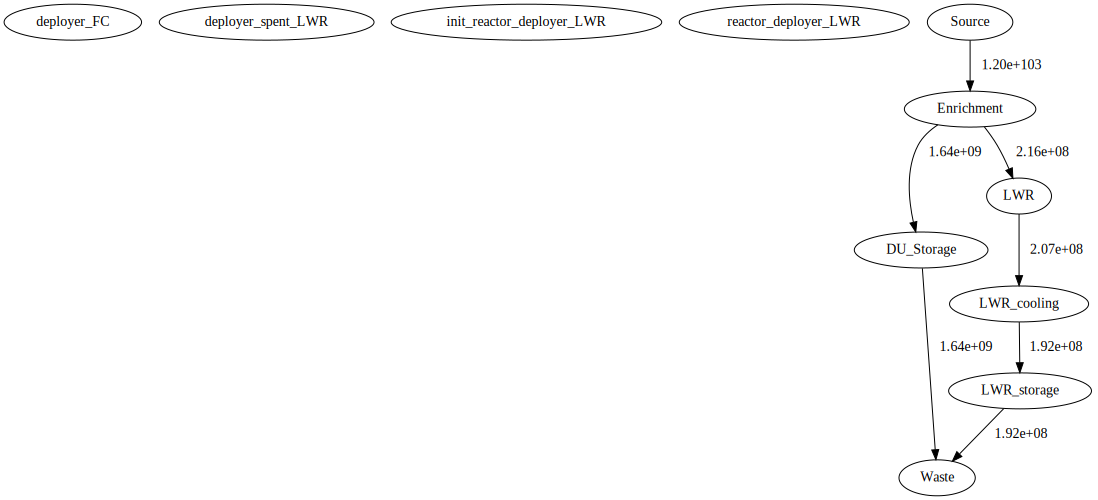

In [3]:
cgr.flow_graph(evd, label='mass')

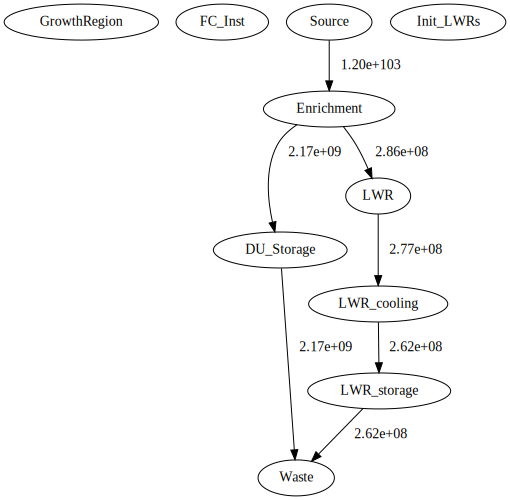

In [89]:
cgr.flow_graph(evg, label='mass')

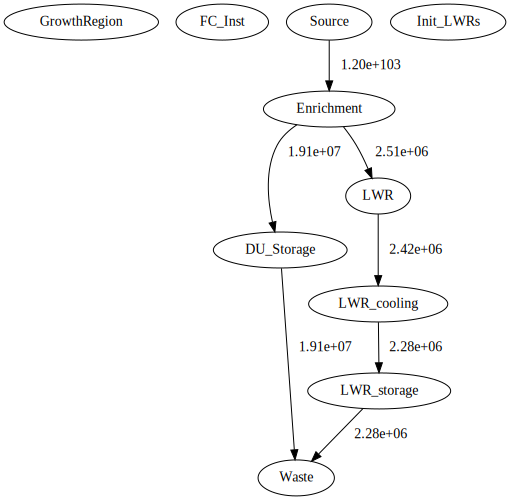

In [78]:
cgr.flow_graph(evt, label='mass')

# Compare the comm decomm (and cumsums) of reactors in each sim (code from cymetric examples)

In [63]:
def rxtr_enter_exit(evaluator):
        
    comm = evaluator.eval('BuildSeries')
    decomm = evaluator.eval('DecommissionSeries')

    neg = -decomm['Count']
    decomm = decomm.drop('Count',axis=1)
    decomm = pd.concat([decomm, neg],axis=1)
    
    comm = comm.rename(columns={'EnterTime':'Time'})
    decomm = decomm.rename(columns={'ExitTime':'Time'})
    
    comm = comm.pivot('Time','Prototype')['Count'].reset_index()
    decomm = decomm.pivot('Time','Prototype')['Count'].reset_index()
    comm_decomm = pd.merge(comm, decomm, left_on='Time', right_on='Time', how='outer', sort=True, \
                           suffixes=('_enter', '_exit')).fillna(0)
    
    comm_decomm.Time = comm_decomm.Time.astype(int)
    
    return comm_decomm

In [138]:
comm_decom_d = rxtr_enter_exit(evd)
comm_decom_g = rxtr_enter_exit(evg)
comm_decom_t = rxtr_enter_exit(evt)

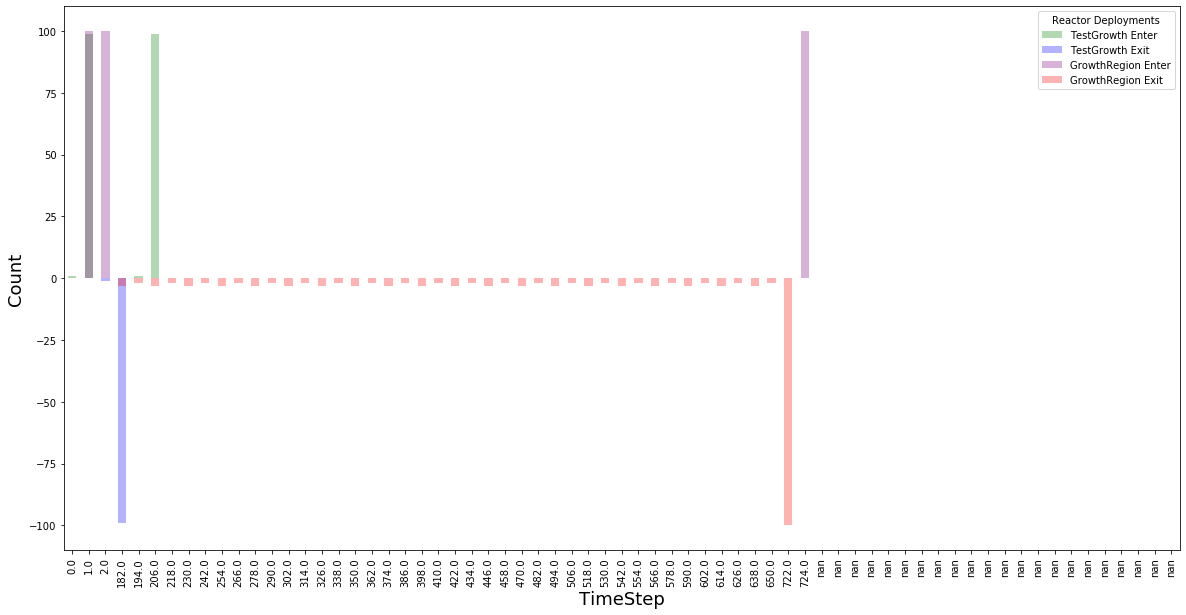

In [139]:
colors_d = ['green', 'blue']
colors_g = ['purple', 'red']

data = [comm_decom_d['Time'], comm_decom_d['LWR_enter'], comm_decom_d['LWR_exit'], 
        comm_decom_g['Time'], comm_decom_g['LWR_enter'], comm_decom_g['LWR_exit'], 
        comm_decom_t['Time'], comm_decom_t['LWR_enter'], comm_decom_t['LWR_exit']
       ]
headers = ['Time (d)', 'Enter (d)', 'Exit (d)', 
           'Time (g)', 'Enter (g)', 'Exit (g)',
           'Time (t)', 'Enter (t)', 'Exit (t)'
          ]
plot_df = pd.concat(data, axis=1, keys=headers)
        
ax = plot_df[['Time (t)', 'Enter (t)', 'Exit (t)']].plot.bar(x='Time (t)', figsize=(20,10), stacked=True, \
                                                              legend=False, color=colors_d, alpha=0.3)
plot_df[['Time (g)', 'Enter (g)', 'Exit (g)']].plot.bar(x='Time (g)', ax=ax, figsize=(20,10), stacked=True, \
                                                       legend=False, color=colors_g, alpha=0.3)
legend = plt.legend()
legend.get_texts()[0].set_text('TestGrowth Enter')#('DeployInst Enter')
legend.get_texts()[1].set_text('TestGrowth Exit')#('DeployInst Exit')
legend.get_texts()[2].set_text('GrowthRegion Enter')
legend.get_texts()[3].set_text('GrowthRegion Exit')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=18)
plt.ylabel(r'Count', fontsize=18)
plt.show()

In [140]:
plot_df[str('deploy') + '_total'] = comm_decom_d[str('LWR') + '_enter'].cumsum() + \
                                    comm_decom_d[str('LWR') + '_exit'].cumsum()

plot_df[str('growth') + '_total'] = comm_decom_g[str('LWR') + '_enter'].cumsum() + \
                                    comm_decom_g[str('LWR') + '_exit'].cumsum()

plot_df[str('test') + '_total'] = comm_decom_t[str('LWR') + '_enter'].cumsum() + \
                                  comm_decom_t[str('LWR') + '_exit'].cumsum()

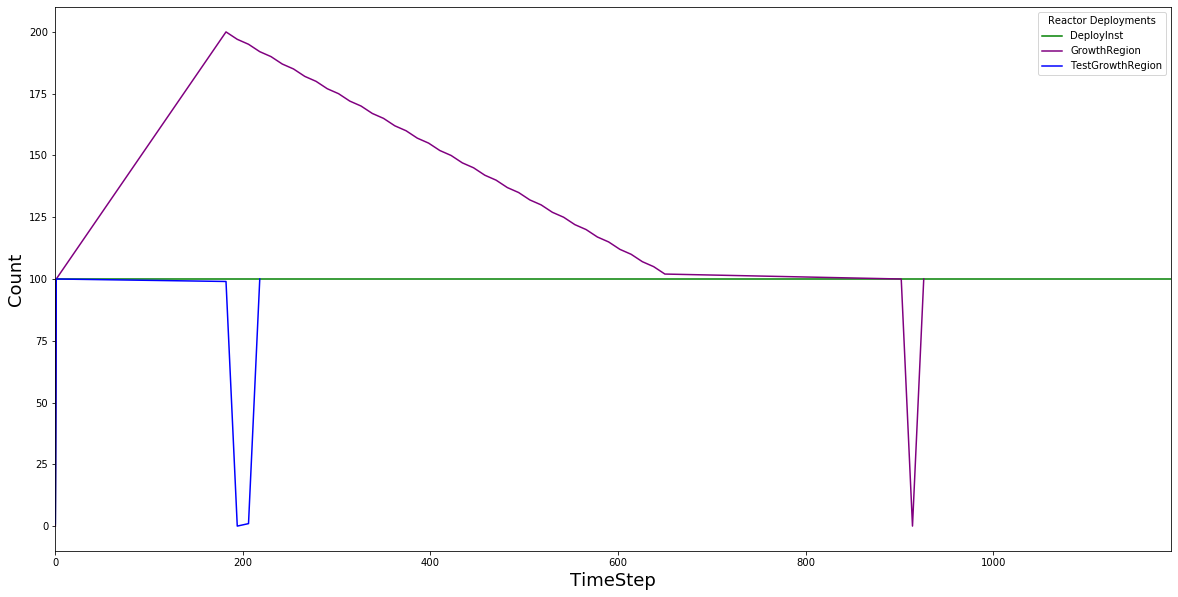

In [141]:
colors = ['green', 'purple', 'blue']
ax = plot_df[['Time (d)', 'deploy_total', 'growth_total', 'test_total']].plot(x='Time (d)', figsize=(20,10), \
                                                                              legend=False, color=colors)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst')
legend.get_texts()[1].set_text('GrowthRegion')
legend.get_texts()[2].set_text('TestGrowthRegion')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=18)
plt.ylabel(r'Count',fontsize=18)
#ax.set_ylim(0, 15)
#ax.set_xlim(175, 210)
plt.show()

# Power Steady @ 100 GWe / yr

In [142]:
df_d = evd.eval('TimeSeriesPower')
df_g = evg.eval('TimeSeriesPower')
df_t = evt.eval('TimeSeriesPower')
# power in GWe
power_d = df_d.groupby(['Time'])['Value'].sum() / 1000.0
power_g = df_g.groupby(['Time'])['Value'].sum() / 1000.0
power_t = df_t.groupby(['Time'])['Value'].sum() / 1000.0

power = pd.DataFrame({'deploy_pwr' : power_d, 'growth_pwr' : power_g, 'test_pwr' : power_t}, index=power_d.index).reset_index()

In [143]:
power

,Time,deploy_pwr,growth_pwr,test_pwr
0,1,100.0,100.0,100.0
1,2,100.0,200.0,100.0
2,3,100.0,200.0,100.0
3,4,100.0,200.0,100.0
4,5,100.0,200.0,100.0
...,...,...,...,...
1194,1195,100.0,100.0,100.0
1195,1196,100.0,100.0,100.0
1196,1197,100.0,100.0,100.0
1197,1198,100.0,100.0,100.0


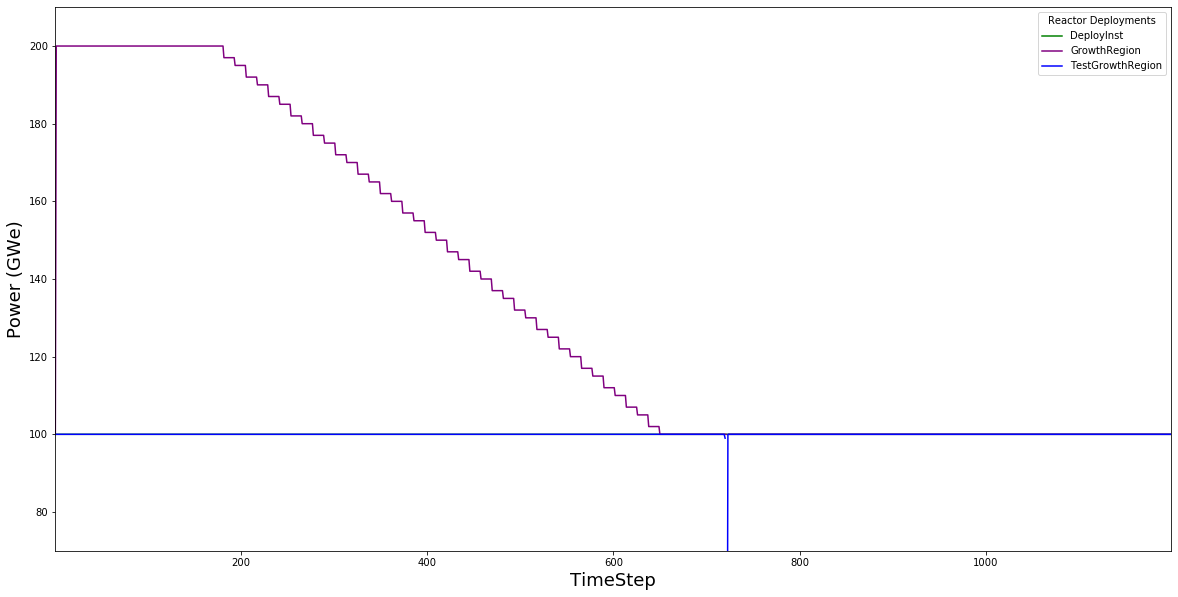

In [144]:
colors = ['green', 'purple', 'blue']
ax = power.plot(x='Time', figsize=(20,10), legend=False, color=colors)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst')
legend.get_texts()[1].set_text('GrowthRegion')
legend.get_texts()[2].set_text('TestGrowthRegion')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=18)
plt.ylabel(r'Power (GWe)',fontsize=18)
ax.set_ylim(70, 210)
#ax.set_xlim(175, 210)
plt.show()